In [1]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size

from utils.utils import *
sr = 16000


In [2]:
model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint a

4436.18310546875 MiB


In [3]:
prompt = "90s rock song with electric guitar and heavy drums."
duration = 120.0 

In [4]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

DEBUG DURATION CONVERSION:
Requested duration: 120.0s
Latent size (time frames): 3072
Latent shape: [1, 8, 3072, 16]
Expected frames per second in latent space: 25.60
Processing chunk 1/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.64it/s]


Processing chunk 2/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:11<00:00, 16.67it/s]


Processing chunk 3/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:11<00:00, 16.74it/s]


Processing chunk 4/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:11<00:00, 16.70it/s]


Processing chunk 5/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.60it/s]


Processing chunk 6/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.54it/s]


Processing chunk 7/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.54it/s]


Processing chunk 8/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


Processing chunk 9/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.31it/s]


Processing chunk 10/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.14it/s]


Processing chunk 11/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.06it/s]


Processing chunk 12/12
SHORT AUDIO: 256 frames <= 256 chunk size - using standard DDIM


Diffusion Steps: 100%|██████████| 200/200 [00:12<00:00, 16.05it/s]



Diffusion time: 145.95s, peak mem: 4692.6 MiB, curr mem: 4449.9 MiB
Final latent shape: torch.Size([1, 8, 3072, 16])
✅ Diffusion latent output is clean (no NaN/Inf)


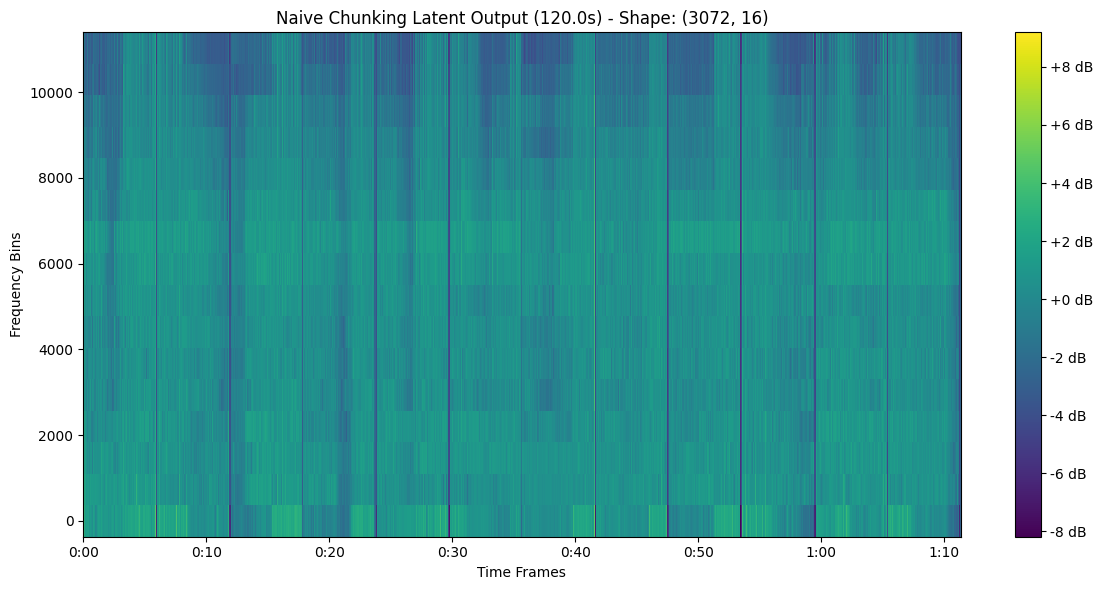

Latent stats - Min: -8.192, Max: 9.193, Mean: 0.112, Std: 1.227


In [5]:
# Run Naive Chunking Diffusion Loop
## Set parameters
ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0
chunk_frames = 256

# Scheduler and initial noise
sampler = DDIMSampler(model)
latent_size = duration_to_latent_t_size(duration)
shape = [1, model.channels, latent_size, model.latent_f_size]
z = torch.randn(shape).to(model.device)

# Debug duration conversion
print(f"DEBUG DURATION CONVERSION:")
print(f"Requested duration: {duration}s")
print(f"Latent size (time frames): {latent_size}")
print(f"Latent shape: {shape}")
print(f"Expected frames per second in latent space: {latent_size / duration:.2f}")

# Memory & timing
memory_before_diffusion = torch.cuda.memory_allocated() / (1024*1024)
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

# Process chunks without overlap
chunks = torch.split(z, chunk_frames, dim=2)
processed_chunks = []

with torch.no_grad():
    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1}/{len(chunks)}")
        processed_chunk = multidiffusion_sample_clean(
            sampler=sampler,
            shape=chunk.shape,
            conditioning=text_emb,
            unconditional_conditioning=unconditional_embedding,
            unconditional_guidance_scale=unconditional_guidance_scale,
            eta=ddim_eta,
            x_T=chunk,
            S=ddim_steps,
            chunk_frames=chunk_frames,
            overlap_frames=0  # No overlap
        )
        processed_chunks.append(processed_chunk)

# Concatenate processed chunks
samples = torch.cat(processed_chunks, dim=2)
torch.cuda.synchronize()

# Report performance
diffusion_time = time.time() - start_time
peak_mem = torch.cuda.max_memory_allocated() / (1024*1024)
curr_mem = torch.cuda.memory_allocated() / (1024*1024)
print(f"Diffusion time: {diffusion_time:.2f}s, peak mem: {peak_mem:.1f} MiB, curr mem: {curr_mem:.1f} MiB")

# Display final latent
print(f"Final latent shape: {samples.shape}")
check_for_nan_inf(samples, "Diffusion latent output")
plot_latent_spectrogram(samples, f"Naive Chunking Latent Output ({duration}s)")

VAE DECODER ISOLATED PEAK: 4714.6 MiB (cost: +264.8 MiB)
VAE DECODER CURRENT MEMORY: 4452.9 MiB
VAE TIME: 0.6s

🔍 VAE DECODER OUTPUT ANALYSIS:
Mel spectrogram shape: torch.Size([1, 1, 12288, 64])
Latent → Mel conversion factor: 4.00x
Mel frames: 12288
Expected mel duration: 196.61s
✅ VAE mel spectrogram output is clean (no NaN/Inf)

📊 MEL SPECTROGRAM (from VAE Decoder):


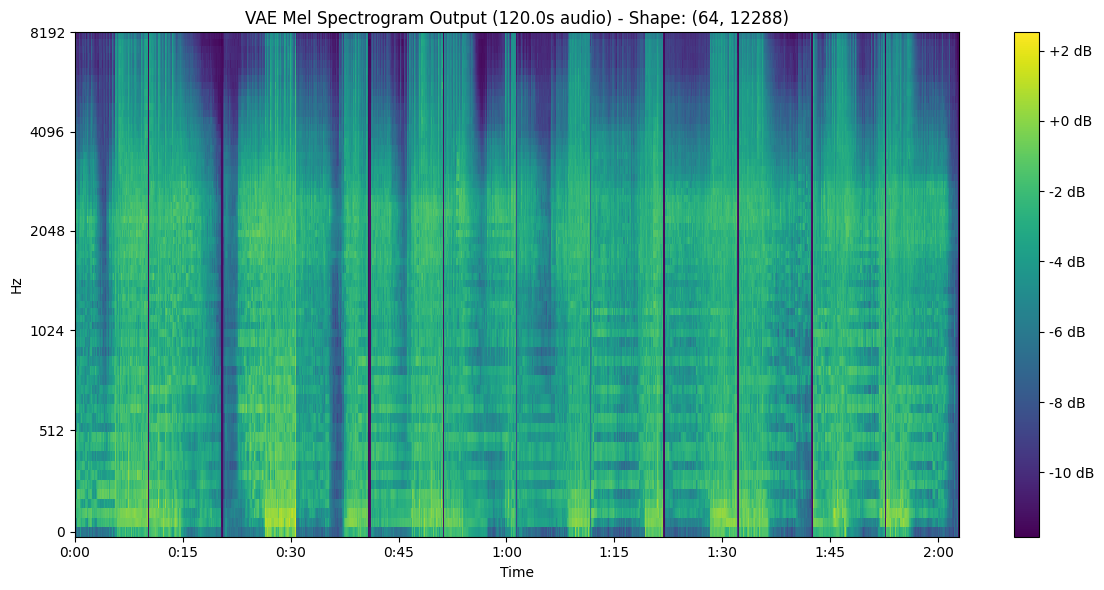

Mel stats - Min: -11.833, Max: 2.519, Mean: -4.305, Std: 2.331


In [6]:
# VAE DECODER - Using sliding window approach for memory efficiency
def sliding_window_vae_decode(model, latents, window_size=256, overlap_size=64):
    """
    Decode latents using a sliding window approach with overlap-add reconstruction.
    This approach avoids complex GroupNorm handling while providing memory savings.
    
    Args:
        model: AudioLDM model with decode_first_stage method
        latents: Input latent tensor [B, C, T, F]
        window_size: Size of each processing window
        overlap_size: Overlap between consecutive windows
    
    Returns:
        mel_spectrogram: Reconstructed mel spectrogram
    """
    B, C, T, F = latents.shape
    step_size = window_size - overlap_size
    
    # Calculate output dimensions
    # VAE typically upsamples by 4x in time dimension
    upsample_factor = 4
    output_mel_frames = T * upsample_factor
    
    # Initialize output tensor (we'll determine mel_bins from first window)
    output_mels = None
    weight_sum = None
    
    # Process windows
    num_windows = (T - overlap_size + step_size - 1) // step_size
    
    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = min(start_idx + window_size, T)
        
        # Extract window
        window_latents = latents[:, :, start_idx:end_idx, :]
        
        # Decode window
        with torch.no_grad():
            window_mel = model.decode_first_stage(window_latents)
        
        # Initialize output tensors on first iteration
        if output_mels is None:
            _, mel_channels, _, mel_bins = window_mel.shape  # Use mel channels, not input channels
            output_mels = torch.zeros(B, mel_channels, output_mel_frames, mel_bins, 
                                    device=window_mel.device, dtype=window_mel.dtype)
            weight_sum = torch.zeros(B, mel_channels, output_mel_frames, mel_bins, 
                                   device=window_mel.device, dtype=window_mel.dtype)
        
        # Calculate output positions
        out_start = start_idx * upsample_factor
        out_end = out_start + window_mel.shape[2]
        out_end = min(out_end, output_mel_frames)
        
        # Create overlap weights (linear fade)
        window_frames = window_mel.shape[2]
        weights = torch.ones(window_frames, device=window_mel.device)
        
        if overlap_size > 0:
            fade_frames = min(overlap_size * upsample_factor, window_frames // 2)
            # Fade in at start
            if i > 0:
                weights[:fade_frames] = torch.linspace(0, 1, fade_frames, device=window_mel.device)
            # Fade out at end
            if i < num_windows - 1:
                weights[-fade_frames:] = torch.linspace(1, 0, fade_frames, device=window_mel.device)
        
        # Apply weights and accumulate
        weighted_mel = window_mel * weights[None, None, :, None]
        weight_tensor = weights[None, None, :, None].expand_as(weighted_mel)
        
        # Add to output (handle potential size mismatch)
        actual_frames = min(window_frames, out_end - out_start)
        output_mels[:, :, out_start:out_start + actual_frames, :] += weighted_mel[:, :, :actual_frames, :]
        weight_sum[:, :, out_start:out_start + actual_frames, :] += weight_tensor[:, :, :actual_frames, :]
    
    # Normalize by weights (avoid division by zero)
    weight_sum = torch.clamp(weight_sum, min=1e-8)
    output_mels = output_mels / weight_sum
    
    # Keep 4D format for vocoder - don't squeeze channel dimension
    # The vocoder expects [B, C, T, F] and handles squeezing internally
    
    return output_mels

# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run VAE with sliding window approach
start_time = time.time()
mel_spectrogram = sliding_window_vae_decode(model, samples, window_size=256, overlap_size=64)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"VAE DECODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VAE DECODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VAE TIME: {vae_time:.1f}s")

# 🔍 VAE DECODER OUTPUT ANALYSIS & VISUALIZATION
print(f"\n🔍 VAE DECODER OUTPUT ANALYSIS:")
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")
print(f"Latent → Mel conversion factor: {mel_spectrogram.shape[2] / samples.shape[2]:.2f}x")
print(f"Mel frames: {mel_spectrogram.shape[2]}")
print(f"Expected mel duration: {mel_spectrogram.shape[2] / 62.5:.2f}s")  # Typical AudioLDM mel rate
check_for_nan_inf(mel_spectrogram, "VAE mel spectrogram output")

# Display mel spectrogram
print(f"\n📊 MEL SPECTROGRAM (from VAE Decoder):")
plot_mel_spectrogram(mel_spectrogram, f"VAE Mel Spectrogram Output ({duration}s audio)", sr=sr)

In [7]:
# VOCODER - Using standard approach for now (will optimize later)
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Debug mel spectrogram dimensions before vocoder
print(f"DEBUG: Mel spectrogram shape before vocoder: {mel_spectrogram.shape}")
print(f"DEBUG: Mel spectrogram dimensions: {mel_spectrogram.dim()}")

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)[0]
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

print(f"\nFINAL RESULTS:")
print(f"Generated {duration}s audio with Naive Chunking")
print(f"Audio shape: {waveform.shape}")
print(f"Audio duration (samples): {len(waveform) / sr:.1f}s")
print(f"Expected samples for {duration}s: {int(duration * sr)}")
print(f"Actual samples: {len(waveform)}")
print(f"Duration discrepancy: {(len(waveform) / sr) - duration:.3f}s")
print(f"Mel → Audio conversion factor: {len(waveform) / mel_spectrogram.shape[2]:.1f}x")
print(f"Overall latent → audio factor: {len(waveform) / samples.shape[2]:.1f}x")

ipd.display(ipd.Audio(waveform, rate=sr))
print(torch.cuda.memory_summary())

DEBUG: Mel spectrogram shape before vocoder: torch.Size([1, 1, 12288, 64])
DEBUG: Mel spectrogram dimensions: 4


VOCODER ISOLATED PEAK: 5895.6 MiB (cost: +1442.8 MiB)
VOCODER CURRENT MEMORY: 4452.9 MiB
VOCODER TIME: 0.8s

FINAL RESULTS:
Generated 120.0s audio with Naive Chunking
Audio shape: (1, 1966112)
Audio duration (samples): 0.0s
Expected samples for 120.0s: 1920000
Actual samples: 1
Duration discrepancy: -120.000s
Mel → Audio conversion factor: 0.0x
Overall latent → audio factor: 0.0x


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4452 MiB |   5895 MiB |  14768 GiB |  14763 GiB |
|       from large pool |   4323 MiB |   5766 MiB |  14172 GiB |  14167 GiB |
|       from small pool |    128 MiB |    128 MiB |    596 GiB |    596 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4452 MiB |   5895 MiB |  14768 GiB |  14763 GiB |
|       from large pool |   4323 MiB |   5766 MiB |  14172 GiB |

In [9]:
import soundfile as sf

# Ensure waveform is a NumPy array and has the correct shape
waveform = waveform.squeeze()  # Remove batch dimension if present
if isinstance(waveform, torch.Tensor):
    waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# Save the generated audio to a file
output_path = "../output/generation"
os.makedirs(output_path, exist_ok=True)
filename = f"naive120s.wav"  # Simplify filename
sf.write(os.path.join(output_path, filename), waveform, sr)

print(f"Audio saved to {os.path.join(output_path, filename)}")

# Random edit
print("Random notebook edit executed!")

Audio saved to ../output/generation/naive120s.wav
Random notebook edit executed!
